In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
import pandas as pd
from transformers import BertTokenizer, BertModel,BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from gensim.models import Word2Vec

%pip install Sastrawi
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

label_type = ['NotPromotion', 'Promotion']

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/shar

In [2]:
# Load the dataset
combined_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/dataset_combined_new - dataset_combined_new.csv', 
                            sep=',', encoding='utf-8', index_col=False)
combined_data = combined_data.drop_duplicates().reset_index(drop=True)
combined_data = combined_data.dropna()

In [3]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421 entries, 0 to 3420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3421 non-null   object
 1   label   3421 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 53.6+ KB


In [4]:
texts = combined_data['text'].values
labels = combined_data['label'].values

In [5]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

lemmatizer = WordNetLemmatizer()

def preprocess_text(texts):
    for index, text in enumerate(texts):
        text = text.lower()

        # text = re.sub(pattern, '', text)

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]

        word_list = [lemmatizer.lemmatize(word) for word in word_list]

        text = ' '.join(word_list)
        texts[index] = text
    return texts

In [6]:
texts = preprocess_text(texts)

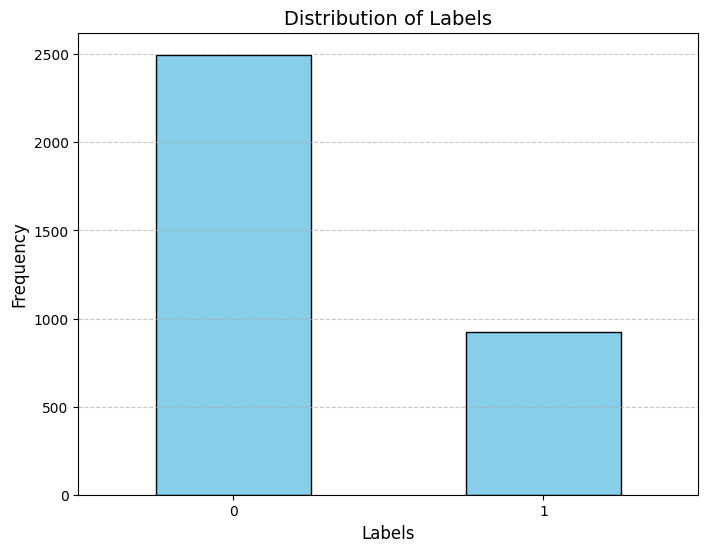

In [7]:
label_counts = combined_data['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Labels', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

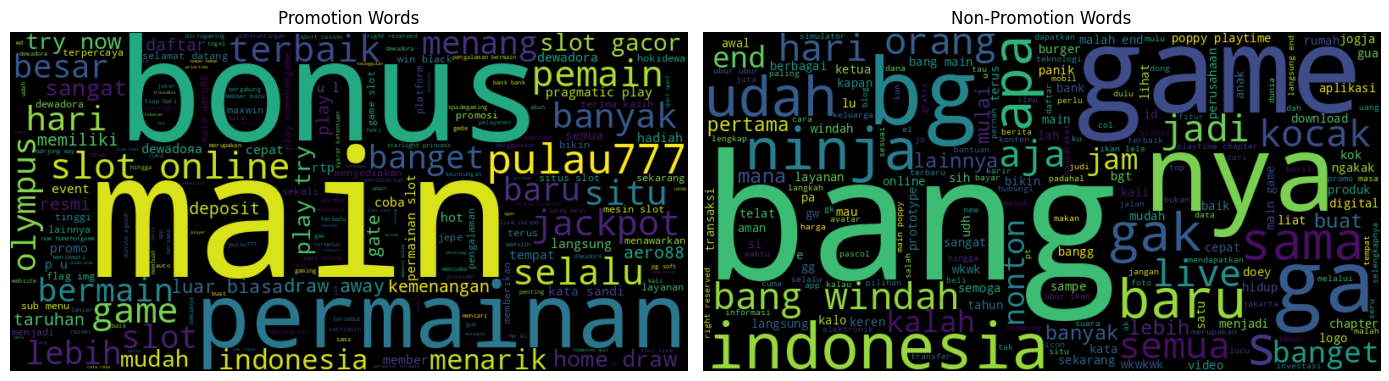

In [8]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate the texts by class
promotion_texts = texts[labels == 1]
non_promotion_texts = texts[labels == 0]

# Generate wordcloud for each class
promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(promotion_texts))
non_promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(non_promotion_texts))

# Plot the wordclouds
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(promotion_wordcloud, interpolation='bilinear')
axes[0].set_title("Promotion Words")
axes[0].axis("off")

axes[1].imshow(non_promotion_wordcloud, interpolation='bilinear')
axes[1].set_title("Non-Promotion Words")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Example model
from sklearn.metrics import accuracy_score
import pickle

# Function to vectorize texts using TF-IDF
def vectorize_texts_tfidf(texts, labels=None):
    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # Fit and transform the texts to obtain the TF-IDF feature vectors
    X_tfidf = tfidf_vectorizer.fit_transform(texts).toarray()

    # If labels are provided, return both features and labels
    if labels is not None:
        with open('tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(tfidf_vectorizer, f)
        y = np.array(labels)
        return X_tfidf, y
        
    
    # If no labels are provided, return only the features
    return X_tfidf

# Convert texts to TF-IDF feature vectors
X, y = vectorize_texts_tfidf(texts, labels)

# Now you can use X and y in your ML model
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y)

# unique_labels, counts = np.unique(y_resampled, return_counts=True)
# for label, count in zip(unique_labels, counts):
#     print(f"Label {label}: {count}")

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=1000,       # More boosting rounds
    max_depth=20,            # Deeper trees
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_val, y_pred))

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       250
           1       0.95      0.87      0.91        92

    accuracy                           0.95       342
   macro avg       0.95      0.93      0.94       342
weighted avg       0.95      0.95      0.95       342

Accuracy: 0.9532
Precision: 0.9524
Recall: 0.8696
F1-score: 0.9091


In [11]:
# Predict and evaluate
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       250
           1       0.93      0.85      0.89        93

    accuracy                           0.94       343
   macro avg       0.94      0.91      0.92       343
weighted avg       0.94      0.94      0.94       343

Accuracy: 0.9417
Precision: 0.9294
Recall: 0.8495
F1-score: 0.8876


Confusion Matrix:



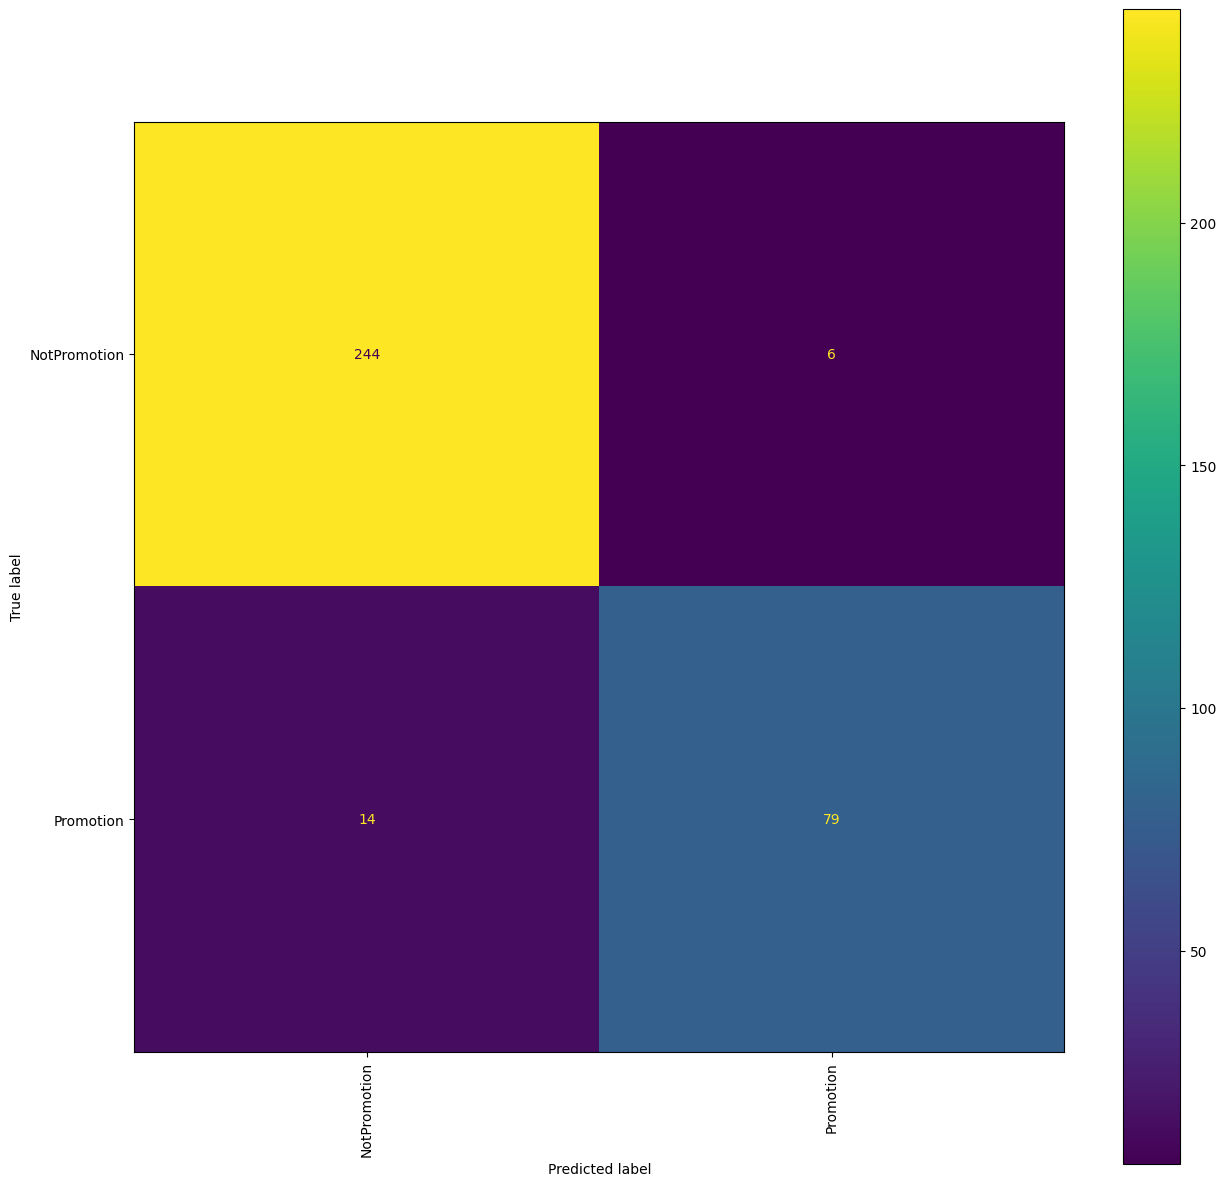

In [12]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_val, y_pred))

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       250
           1       1.00      0.90      0.95        92

    accuracy                           0.97       342
   macro avg       0.98      0.95      0.97       342
weighted avg       0.97      0.97      0.97       342

Accuracy: 0.9737
Precision: 1.0000
Recall: 0.9022
F1-score: 0.9486


In [14]:
# Predict and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       250
           1       0.97      0.91      0.94        93

    accuracy                           0.97       343
   macro avg       0.97      0.95      0.96       343
weighted avg       0.97      0.97      0.97       343

Accuracy: 0.9679
Precision: 0.9659
Recall: 0.9140
F1-score: 0.9392


Confusion Matrix:



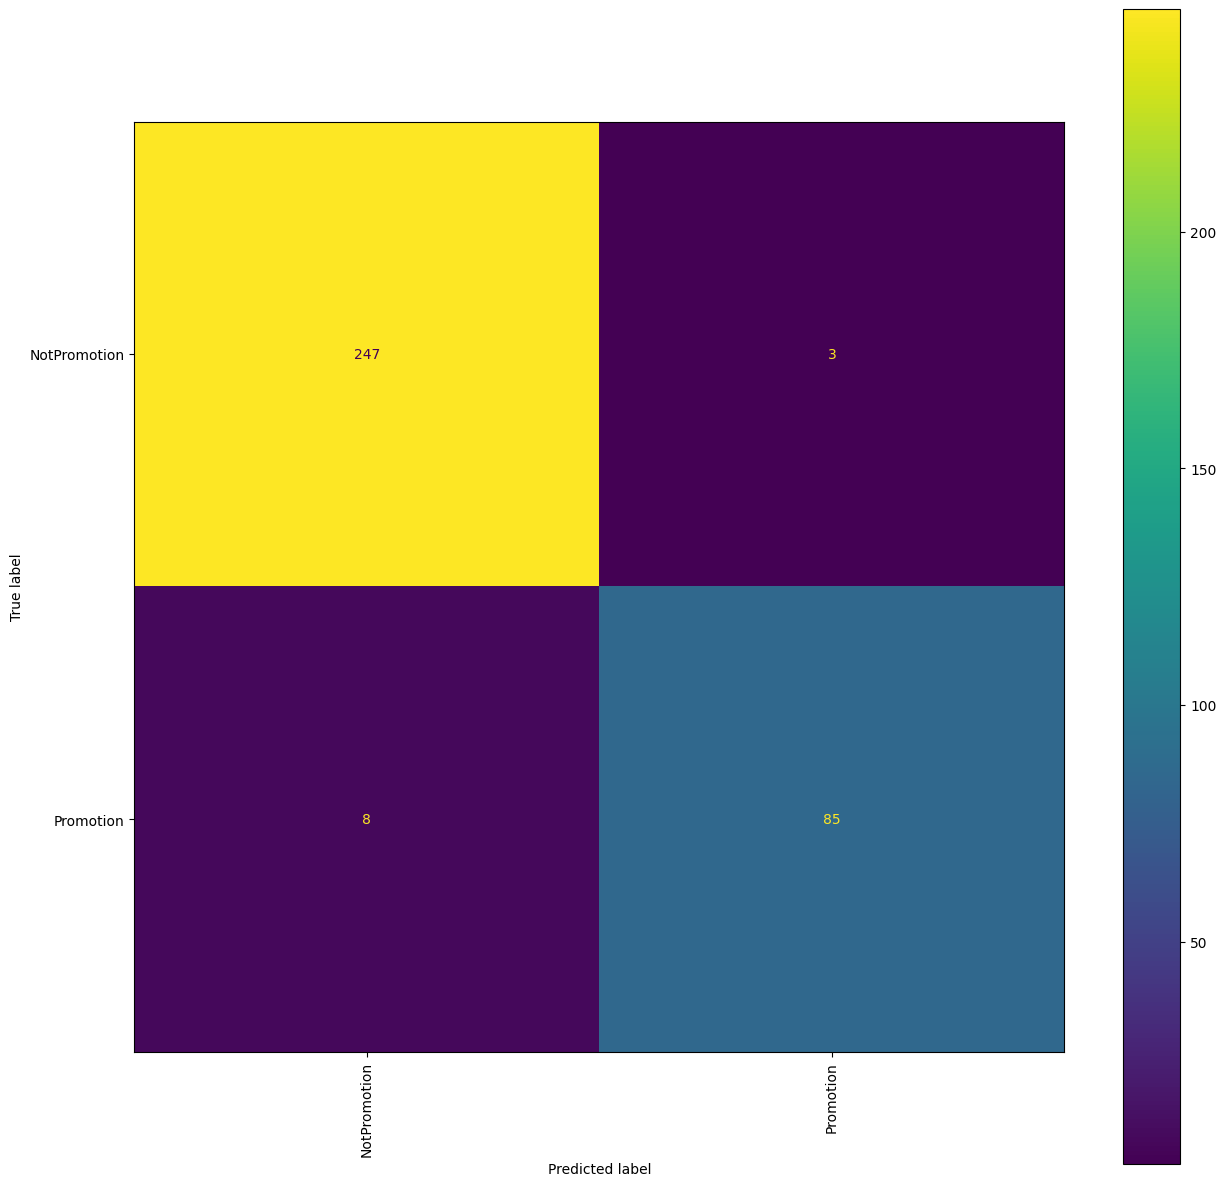

In [15]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')